In [20]:
%%capture
!pip install scanpy
!pip install hnswlib
!pip install ivis
!pip install pytorch_metric_learning
!pip install igraph
!pip install louvain
!pip install leidenalg

In [21]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import hnswlib
import networkx as nx
import itertools
from scipy.sparse import issparse
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score,adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from ivis.nn.losses import *
from ivis.nn.network import triplet_network
from sklearn.cluster import KMeans
import torch
import scipy
# For computing graph distances:
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph

# For pre-processing, normalization
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import silhouette_samples, silhouette_score

import os
import logging
from annoy import AnnoyIndex
import math,time
from joblib import Parallel, delayed
import random
import sys
from numpy.linalg import matrix_power
from numpy import linalg as LA
from tqdm import tqdm

In [22]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/comp/545_FINAL")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## preprocess

In [23]:
def logNormalization(adata):
  adata.obs['n_counts'] = adata.X.sum(axis=1).A1
  adata.obs['size_factor']=adata.obs['n_counts']/1e6
  adata.raw=adata.copy()
  sc.pp.normalize_total(adata,target_sum=1e6)
  sc.pp.log1p(adata)
  return adata

def preprocessing(datasets, min_cells=1, min_genes=1, n_top_genes=2000, mt_ratio=0.8, lognorm=True, hvg=True,
				index_unique=None):
	if lognorm:
		for i in range(len(datasets)):
			sc.pp.filter_genes(datasets[i],min_cells=min_cells)
			sc.pp.filter_cells(datasets[i],min_genes=min_genes)
			mito_genes = datasets[i].var_names.str.upper().str.startswith('MT-')
			datasets[i].obs['percent_mito'] = np.sum(datasets[i][:, mito_genes].X, axis=1).A1 / np.sum(datasets[i].X, axis=1).A1
			datasets[i] = datasets[i][datasets[i].obs['percent_mito'] < mt_ratio, :]
			datasets[i]=logNormalization(datasets[i])
	all_features=pd.Index([])
	for i in range(len(datasets)):
		all_features=all_features.union(datasets[i].var_names)
	common_features=all_features
	for i in range(len(datasets)):
		common_features=common_features.intersection(datasets[i].var.index)
	df_var = pd.DataFrame(index=all_features)
	df_var['selected']=0
	if hvg:
		for i in range(len(datasets)):
			sc.pp.highly_variable_genes(datasets[i], flavor='seurat', n_top_genes =n_top_genes , inplace=True)
			features = datasets[i].var_names[datasets[i].var['highly_variable']]
			df_var.loc[features]+=1
		df_var=df_var.loc[common_features]
		df_var.sort_values(by="selected", ascending=False, inplace=True)
		selected_features=df_var.index[range(n_top_genes)]
	else:
		selected_features=common_features
	for i in range(len(datasets)):
		datasets[i] = datasets[i][:,selected_features]
		if i==0:
			adata=datasets[i]
		else:
			adata=adata.concatenate(datasets[i],index_unique =index_unique)

	sc.pp.scale(adata, max_value=10)
	sc.tl.pca(adata, svd_solver='arpack')
	return adata

def analyze_single_cell_rna(a,n_pc,rep, key):
	sc.pp.neighbors(a, n_pcs = n_pc, use_rep = rep)
	sc.tl.umap(a)
	sc.tl.leiden(a, resolution=0.3, key_added=key)
	sc.tl.umap(a, spread=1.0, min_dist=0.5, random_state=11)
	sc.tl.rank_genes_groups(a, 'celltype', method='t-test')
	return a

In [24]:
adata_rna = sc.read("./rna.h5ad")
adata_atac = sc.read("./geneact.h5ad")
adata_merge = preprocessing([adata_rna, adata_atac])

## scDML

In [25]:
def checkInput(adata,batch_key):

    if not isinstance(adata,AnnData):
        raise IOError

    if batch_key is not None and batch_key not in adata.obs.columns:
        raise IOError
    elif batch_key is None:
        batch_key="BATCH"
        adata.obs[batch_key]="1"

    if(adata.obs[batch_key].dtype.name != "categroy"):
        adata.obs[batch_key]=adata.obs[batch_key].astype("category")
    return batch_key

In [26]:
def nn_approx(ds1, ds2, names1, names2, knn=50, return_distance=False,metric="cosine",flag="in"):
    dim = ds2.shape[1]
    num_elements = ds2.shape[0]
    if(metric=="euclidean"):
        tree = hnswlib.Index(space="l2", dim=dim)
    elif(metric=="cosine"):
        tree = hnswlib.Index(space="cosine", dim=dim)
    tree.init_index(max_elements=num_elements, ef_construction=200, M=32) # refer to https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md for detail
    tree.set_ef(50)
    tree.add_items(ds2)
    ind, distances = tree.knn_query(ds1, k=knn)
    if(flag=="in"):
        if not return_distance:
            match = set()
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b[1:]:##
                    match.add((names1[a], names2[b_i]))
            return match
        else:
            match = {}
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_ind, b_i in enumerate(b):
                    match[(names1[a], names2[b_i])] = distances[a, b_ind]  # not sure this is fast
                    # match.add((names1[a], names2[b_i]))
            return match
    else:
        if not return_distance:
            match = set()
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b[0:]:##
                    match.add((names1[a], names2[b_i]))
            return match
        else:
            match = {}
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_ind, b_i in enumerate(b):
                    match[(names1[a], names2[b_i])] = distances[a, b_ind]  # not sure this is fast
                    # match.add((names1[a], names2[b_i]))
            return match

def nn(ds1, ds2, names1, names2, knn=50, metric_p=2, return_distance=False,metric="cosine",flag="in"):
    # Find nearest neighbors of first dataset.
    if(flag=="in"):
        nn_ = NearestNeighbors(n_neighbors=knn, metric=metric)  # remove self
        nn_.fit(ds2)
        nn_distances, ind = nn_.kneighbors(ds1, return_distance=True)
        if not return_distance:
            match = set()
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b[1:]:
                    match.add((names1[a], names2[b_i]))
            return match
        else:
            match = {}
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_ind, b_i in enumerate(b):
                    match[(names1[a], names2[b_i])] = nn_distances[a, b_ind]  # not sure this is fast
                    # match.add((names1[a], names2[b_i]))
            return match
    else:
        nn_ = NearestNeighbors(n_neighbors=knn, metric=metric)  # remove self
        nn_.fit(ds2)
        nn_distances, ind = nn_.kneighbors(ds1, return_distance=True)
        if not return_distance:
            match = set()
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b[0:]:
                    match.add((names1[a], names2[b_i]))
            return match
        else:
            match = {}
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_ind, b_i in enumerate(b):
                    match[(names1[a], names2[b_i])] = nn_distances[a, b_ind]  # not sure this is fast
                    # match.add((names1[a], names2[b_i]))
            return match

def nn_annoy(ds1, ds2, names1, names2, knn=20,save=True, return_distance=False,metric="cosine",flag="in"):
    """ Assumes that Y is zero-indexed. """
    # Build index.
    if(metric=="cosine"):
        tree = AnnoyIndex(ds2.shape[1], metric="angular")#metric
        tree.set_seed(100)
    else:
        tree = AnnoyIndex(ds2.shape[1], metric=metric)#metric
        tree.set_seed(100)
    if save:
        tree.on_disk_build('annoy.index')
    for i in range(ds2.shape[0]):
        tree.add_item(i, ds2[i, :])
    tree.build(60)#n_trees=50
    # Search index.
    ind = []
    for i in range(ds1.shape[0]):
        ind.append(tree.get_nns_by_vector(ds1[i, :], knn, search_k=-1)) #search_k=-1 means extract search neighbors
    ind = np.array(ind)
    # Match.
    if(flag=="in"):
        if not return_distance:
            match = set()
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b[1:]:
                    match.add((names1[a], names2[b_i]))
            return match
        else:
            # get distance
            match = {}
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b:
                    match[(names1[a], names2[b_i])] = tree.get_distance(a, b_i)
            return match
    else:
        if not return_distance:
            match = set()
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b[0:]:
                    match.add((names1[a], names2[b_i]))
            return match
        else:
            # get distance
            match = {}
            for a, b in zip(range(ds1.shape[0]), ind):
                for b_i in b:
                    match[(names1[a], names2[b_i])] = tree.get_distance(a, b_i)
            return match

def mnn(ds1, ds2, names1, names2, knn=20, save=False, approx=True,approx_method="hnswlib", return_distance=False,metric="cosine",flag="in"):
    # Find nearest neighbors in first direction.

    if approx:
        if approx_method=="hnswlib":
            #hnswlib
            match1 = nn_approx(ds1, ds2, names1, names2, knn=knn,return_distance=return_distance,metric=metric,flag=flag)  # save_on_disk = save_on_disk)
            # Find nearest neighbors in second direction.
            match2 = nn_approx(ds2, ds1, names2, names1, knn=knn,return_distance=return_distance,metric=metric,flag=flag)  # , save_on_disk = save_on_disk)
        else:
            #annoy
            match1 = nn_annoy(ds1, ds2, names1, names2, knn=knn,save=save,return_distance=return_distance,metric=metric,flag=flag)  # save_on_disk = save_on_disk)
            # Find nearest neighbors in second direction.
            match2 = nn_annoy(ds2, ds1, names2, names1, knn=knn,save=save,return_distance=return_distance,metric=metric,flag=flag)  # , save_on_disk = save_on_disk)

    else:
        match1 = nn(ds1, ds2, names1, names2, knn=knn, return_distance=return_distance,metric=metric,flag=flag)
        match2 = nn(ds2, ds1, names2, names1, knn=knn, return_distance=return_distance,metric=metric,flag=flag)
    # Compute mutual nearest neighbors.
    if(flag=="in"):
        if not return_distance:
            # mutal are set
            mutual = match1 | set([(b, a) for a, b in match1])
            return mutual
        else:
            # mutal are set
            mutual = set([(a, b) for a, b in match1.keys()]) | set([(b, a) for a, b in match2.keys()])
            #distance list of numpy array
            distances = []
            for element_i in mutual:
                distances.append(match1[element_i])  # distance is sys so match1[element_i]=match2[element_2]
            return mutual, distances
    else:
        if not return_distance:
            # mutal are set
            mutual = match1 & set([(b, a) for a, b in match2])
            ####################################################
            # change mnn pair to symmetric
            mutual = mutual | set([(b,a) for (a,b) in mutual])
            ####################################################
            return mutual
        else:
            # mutal are set
            mutual = set([(a, b) for a, b in match1.keys()]) & set([(b, a) for a, b in match2.keys()])
            #distance list of numpy array
            distances = []
            for element_i in mutual:
                distances.append(match1[element_i])  # distance is sys so match1[element_i]=match2[element_2]
            return mutual, distances


## calculate KNN and MNN from data_matrix(embedding matrix) not anndata
def get_dict_mnn(data_matrix, batch_index, k=5, save=True, approx=True,approx_method="hnswlib", return_distance=False,metric="cosine",flag="in"):

    #ipdb.set_trace()
    #assert type(adata) == sc.AnnData, "Please make sure `adata` is sc.AnnData"
    cell_names = np.array(range(len(data_matrix)))
    #batch_list = adata.obs[batch_key] if batch_key in adata.obs.columns else np.ones(adata.shape[0], dtype=str)
    batch_unique = np.unique(batch_index)
    cells_batch = []
    for i in batch_unique:
        cells_batch.append(cell_names[batch_index == i])
    mnns = set()
    mnns_distance = []
    if(flag=="in"):
        num_KNN=0
        for comb in list(itertools.combinations(range(len(cells_batch)), 1)):
            # comb=(2,3)
            i = comb[0]  # ith batch
            j = comb[0]  # ith batch
            target = list(cells_batch[j])
            ref = list(cells_batch[i])
            #ds1 = adata[target].obsm[dr_name]
            ds1=data_matrix[target]
            ds2=data_matrix[ref]
            names1 = target
            names2 = ref
            match = mnn(ds1, ds2, names1, names2, knn=k, save=save, approx=approx,approx_method=approx_method, return_distance=return_distance,metric=metric,flag=flag)
            mnns=mnns|match
        #print("done")
        if not return_distance:
            return mnns
        else:
            return mnns, mnns_distance
    else:
        num_MNN=0
        for comb in list(itertools.combinations(range(len(cells_batch)), 2)):
            # comb=(2,3)
            i = comb[0]  # i batch
            j = comb[1]  # jth batch

            target = list(cells_batch[j])
            ref = list(cells_batch[i])
            ds1 = data_matrix[target]
            ds2 = data_matrix[ref]
            names1 = target
            names2 = ref
            match = mnn(ds1, ds2, names1, names2, knn=k, save=save, approx=approx,approx_method=approx_method, return_distance=return_distance,metric=metric,flag=flag)
            mnns=mnns|match
            #mnns_distance.append(distances)
        #print("done")
        if not return_distance:
            return mnns
        else:
            return mnns, mnns_distance


## calculate KNN and MNN from data_matrix(embedding matrix) not anndata in parallel mode
def get_dict_mnn_para(data_matrix, batch_index, k=5, save=True, approx=True,approx_method="hnswlib", return_distance=False,metric="cosine",flag="in",njob=8):

    #ipdb.set_trace()
    #assert type(adata) == sc.AnnData, "Please make sure `adata` is sc.AnnData"
    cell_names = np.array(range(len(data_matrix)))
    #batch_list = adata.obs[batch_key] if batch_key in adata.obs.columns else np.ones(adata.shape[0], dtype=str)
    batch_unique = np.unique(batch_index)
    cells_batch = []
    for i in batch_unique:
        cells_batch.append(cell_names[batch_index == i])
    mnns = set()
    mnns_distance = []
    if(flag=="in"):
        num_KNN=0

        res = Parallel(n_jobs=njob)(delayed(mnn)(data_matrix[list(cells_batch[comb[0]])],data_matrix[list(cells_batch[comb[0]])] , list(cells_batch[comb[0]]), list(cells_batch[comb[0]]), knn=k, save=save, approx=approx,approx_method=approx_method, return_distance=return_distance,metric=metric,flag=flag) for comb in list(itertools.combinations(range(len(cells_batch)), 1)))

        mnns=list(itertools.chain(*res))
        #print("done")
        if not return_distance:
            return mnns
        else:
            return mnns, mnns_distance
    else:
        num_MNN=0

        res = Parallel(n_jobs=njob)(delayed(mnn)(data_matrix[list(cells_batch[comb[1]])],data_matrix[list(cells_batch[comb[0]])] , list(cells_batch[comb[1]]), list(cells_batch[comb[0]]), knn=k, save=save, approx=approx,approx_method=approx_method, return_distance=return_distance,metric=metric,flag=flag) for comb in list(itertools.combinations(range(len(cells_batch)), 2)))

        mnns=list(itertools.chain(*res))
        #print("done")
        if not return_distance:
            return mnns
        else:
            return mnns, mnns_distance

def cal_sim_matrix(knn_in_batch,mnn_out_batch,cluster_label):

    cluster_set=range(len(np.unique(cluster_label)))
    mnn_inbatch_df=pd.DataFrame({"pair1_clust":cluster_label[knn_in_batch[:,0]].astype(int),
                           "pair2_clust":cluster_label[knn_in_batch[:,1]].astype(int),
                           "pair1":knn_in_batch[:,0],
                           "pair2":knn_in_batch[:,1]})
    knn_summary=pd.crosstab(mnn_inbatch_df.pair1_clust,mnn_inbatch_df.pair2_clust)

    knn_table=pd.DataFrame(0, index=cluster_set, columns=cluster_set)
    for ind in list(knn_summary.index):
        for col in list(knn_summary.columns):
            knn_table.loc[ind,col]=knn_summary.loc[ind,col]
    np.fill_diagonal(knn_table.values,0)

    if(len(mnn_out_batch)==0): # no mnn pair
        mnn_summary=pd.DataFrame(0, index=cluster_set, columns=cluster_set)
    else: # have mnn pair
        mnn_bwbatch_df=pd.DataFrame({"pair1_clust":cluster_label[mnn_out_batch[:,0]].astype(int),
                            "pair2_clust":cluster_label[mnn_out_batch[:,1]].astype(int),
                            "pair1":mnn_out_batch[:,0],
                            "pair2":mnn_out_batch[:,1]})
        mnn_summary=pd.crosstab(mnn_bwbatch_df.pair1_clust,mnn_bwbatch_df.pair2_clust)
    mnn_table=pd.DataFrame(0, index=cluster_set, columns=cluster_set)
    for ind in list(mnn_summary.index):
        for col in list(mnn_summary.columns):
            mnn_table.loc[ind,col]=mnn_summary.loc[ind,col]
    np.fill_diagonal(mnn_table.values,0)
    ## calucate link conectivity between cluster
    sum_matrix=knn_table.values+mnn_table.values
    link_nn=knn_table + mnn_table
    mnn_cor=np.zeros_like(sum_matrix,dtype=float)
    clu_size=np.array(cluster_label.value_counts())
    for i in range(len(mnn_cor)):
        for j in range(len(mnn_cor)):
            mnn_cor[i,j]=sum_matrix[i,j].astype(float)/min(clu_size[i],clu_size[j])

    cor=pd.DataFrame(data=mnn_cor)
    cor_mat=cor.values
    np.fill_diagonal(cor_mat, -1)
    return cor,link_nn

In [27]:
def find_threshold(n_clusters,cor_mat):
    cor=cor_mat.copy()
    iteration = 0
    threhold = [0., 20.]
    obtained_clusters = -1

    while obtained_clusters != n_clusters and iteration < 50:
        current_thre = sum(threhold)/2
        #print("threshold={}".format(current_thre))
        G=nx.Graph()
        near_cluster=dict()
        cluster_set=set()
        for i in range(cor.shape[0]):
            near_cluster[i]=i
        for i in range(len(cor)):
            for j in range(i+1,len(cor)):
                if(cor.values[i,j]>=current_thre):
                    if(cor.values[j,i]>cor.values[j,near_cluster[j]]):
                        near_cluster[j]=i

        for i in near_cluster.keys():
            cluster_set.add((i,near_cluster[i]))
            cluster_set.add((near_cluster[i],i))

        edge_set=cluster_set.copy()
        G.add_edges_from(edge_set)
        obtained_clusters=nx.number_connected_components(G)
        if obtained_clusters < n_clusters:
            threhold[0] = current_thre
        else:
            threhold[1] = current_thre
        iteration = iteration + 1
    print("=================when ncluster={},threhold={}=====".format(n_clusters,current_thre))
    return current_thre


def merge_rule1(cor,num_init_cluster,n_cluster=None,threshold=None,save_dir=None):
    if(n_cluster is None and threshold is None):
        print("please provide a fixed threshold or a fixed n_cluster")
        raise IOError
    if(n_cluster is None): # suppose if don't provide n_cluster, the threshold muse be provided
        cluster_set=set()
        near_cluster=dict()
        for i in range(num_init_cluster):
            near_cluster[i]=i
        for i in range(len(cor)):
            for j in range(i+1,len(cor)):
                if(cor.values[i,j]>=threshold):##
                    if(cor.values[j,i]>cor.values[j,near_cluster[j]]):
                        near_cluster[j]=i
        for i in near_cluster.keys():
            cluster_set.add((i,near_cluster[i]))
            cluster_set.add((near_cluster[i],i))
        G=nx.Graph()
        edge_set=cluster_set.copy()
        G.add_edges_from(edge_set)
        map_set=list(nx.connected_components(G))
        return map_set
    else:
        threshold=find_threshold(n_cluster,cor)
        cluster_set=set()
        near_cluster=dict()
        for i in range(num_init_cluster):
            near_cluster[i]=i

        for i in range(len(cor)):
            for j in range(i+1,len(cor)):
                if(cor.values[i,j]>=threshold):##
                    if(cor.values[j,i]>cor.values[j,near_cluster[j]]):
                        near_cluster[j]=i
        for i in near_cluster.keys():
            cluster_set.add((i,near_cluster[i]))
            cluster_set.add((near_cluster[i],i))
        G=nx.Graph()
        edge_set=cluster_set.copy()
        G.add_edges_from(edge_set)
        map_set=list(nx.connected_components(G))
        return map_set

def merge_rule2(sim_matrix,NN_pair,cluster_size,n_cluster=None,threshold=None):
    if(threshold is None):
        if(type(list(sim_matrix.columns)[0])!=str):
            temp_col_names=list(sim_matrix.columns)
            sim_matrix.columns=[str(i) for i in temp_col_names]
        sim_matrix.columns="cluster_"+sim_matrix.columns
        sim_matrix.index=list(sim_matrix.columns)

        NN_pair.columns=sim_matrix.columns
        NN_pair.index=list(sim_matrix.columns)

        cluster_size=pd.DataFrame(cluster_size)
        cluster_size.columns=["init_cluster_num"]
        cluster_size.index=list(sim_matrix.columns)##convert to dataframe

        NN_pair_mat=NN_pair.values
        num_clu=len(cluster_size)
        cnt=0
        max_clu=num_clu
        map_dict={}
        for i in list(sim_matrix.index):
            map_dict[i]=None
        df=sim_matrix.copy()
        while(df.shape[1]>n_cluster):
            max_sim = -math.inf
            for i in list(df.index):
                for j in list(df.columns):
                    cnt=cnt+1
                    val=df.loc[i,j]
                    if val > max_sim:
                        max_sim = val
                        closest_part = (i, j)

            # delete two merged cluster
            del_cluster=list(closest_part)
            df =df.drop(labels=del_cluster)
            df =df.drop(labels=del_cluster,axis=1)
            ind=list(df.index)
            ## add new cluster(cluster_size)
            new_cluster_name="cluster_"+str(max_clu)
            #print(str(closest_part)+" merged to {}".format(new_cluster_name))
            map_dict[new_cluster_name]=list(closest_part)
            cluster_size.loc[new_cluster_name]=cluster_size.loc[closest_part[0],"init_cluster_num"]+cluster_size.loc[closest_part[1],"init_cluster_num"]
            #print(cluster_size)
            NN_pair.loc[new_cluster_name] =NN_pair.loc[closest_part[0]].values +NN_pair.loc[closest_part[1]].values
            row_val=np.append(NN_pair.loc[new_cluster_name].values,0)
            NN_pair[new_cluster_name]=row_val
            if(df.empty):# when ncluster=1,df is empy
                max_clu=max_clu+1
                df=pd.DataFrame(np.array([[1]]),index=[new_cluster_name],columns=[new_cluster_name])
            else:
                df.loc[new_cluster_name] = -1
                for col in df.columns:
                    min_size=min(cluster_size.loc[new_cluster_name,"init_cluster_num"],cluster_size.loc[col,"init_cluster_num"])
                    df.loc[new_cluster_name,col]=NN_pair.loc[new_cluster_name,col]/min_size

                row_val=np.append(df.loc[new_cluster_name].values,0)
                df[new_cluster_name]=row_val
                max_clu=max_clu+1
        # define recurve function to find cluster connection
        def leaf_traversal(node,s):
            if map_dict[node] is None:
                #s.add(node)
                s.add(int(node.split("_")[1]))
            else:
                if map_dict[node][0] is not None:
                    leaf_traversal(map_dict[node][0], s)
                if map_dict[node][1] is not None:
                    leaf_traversal(map_dict[node][1], s)

        final_merged=list(df.columns)
        final_conected=[set() for _ in range(len(final_merged))]
        for i in range(len(final_merged)):
            leaf_traversal(final_merged[i],final_conected[i])
        map_set=final_conected.copy()
        return map_set
    else:
        print("thresold is set to {}".format(threshold))
        if(type(list(sim_matrix.columns)[0])!=str):
            temp_col_names=list(sim_matrix.columns)
            sim_matrix.columns=[str(i) for i in temp_col_names]
        sim_matrix.columns="cluster_"+sim_matrix.columns
        sim_matrix.index=list(sim_matrix.columns)

        NN_pair.columns=sim_matrix.columns
        NN_pair.index=list(sim_matrix.columns)

        cluster_size=pd.DataFrame(cluster_size)
        cluster_size.columns=["init_cluster_num"]
        cluster_size.index=list(sim_matrix.columns)##convert to dataframe

        NN_pair_mat=NN_pair.values
        num_clu=len(cluster_size)
        cnt=0
        max_clu=num_clu
        map_dict={}
        for i in list(sim_matrix.index):
            map_dict[i]=None
        df=sim_matrix.copy()
        while(max(df.max())>= threshold ):
            max_sim = -math.inf
            for i in list(df.index):
                for j in list(df.columns):
                    cnt=cnt+1
                    val=df.loc[i,j]
                    if val > max_sim:
                        max_sim = val
                        closest_part = (i, j)

            # delete two merged cluster
            del_cluster=list(closest_part)
            df =df.drop(labels=del_cluster)
            df =df.drop(labels=del_cluster,axis=1)
            ind=list(df.index)
            ## add new cluster(cluster_size)
            new_cluster_name="cluster_"+str(max_clu)
            #print(str(closest_part)+" merged to {}".format(new_cluster_name))
            map_dict[new_cluster_name]=list(closest_part)
            cluster_size.loc[new_cluster_name]=cluster_size.loc[closest_part[0],"init_cluster_num"]+cluster_size.loc[closest_part[1],"init_cluster_num"]
            #print(cluster_size)
            NN_pair.loc[new_cluster_name] =NN_pair.loc[closest_part[0]].values +NN_pair.loc[closest_part[1]].values
            row_val=np.append(NN_pair.loc[new_cluster_name].values,0)
            NN_pair[new_cluster_name]=row_val
            if(df.empty):# when ncluster=1,df is empy
                #print("df is empty...")
                max_clu=max_clu+1
                df=pd.DataFrame(np.array([[1]]),index=[new_cluster_name],columns=[new_cluster_name])
            else:
                df.loc[new_cluster_name] = -1
                for col in df.columns:
                    min_size=min(cluster_size.loc[new_cluster_name,"init_cluster_num"],cluster_size.loc[col,"init_cluster_num"])
                    df.loc[new_cluster_name,col]=NN_pair.loc[new_cluster_name,col]/min_size

                row_val=np.append(df.loc[new_cluster_name].values,0)
                df[new_cluster_name]=row_val
                max_clu=max_clu+1
        # define recurve function to find cluster connection
        def leaf_traversal(node,s):
            if map_dict[node] is None:
                #s.add(node)
                s.add(int(node.split("_")[1]))
            else:
                if map_dict[node][0] is not None:
                    leaf_traversal(map_dict[node][0], s)
                if map_dict[node][1] is not None:
                    leaf_traversal(map_dict[node][1], s)
        final_merged=list(df.columns)
        final_conected=[set() for _ in range(len(final_merged))]
        for i in range(len(final_merged)):
            leaf_traversal(final_merged[i],final_conected[i])

        map_set=final_conected.copy()
        return map_set

In [28]:
import torch.nn as nn
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.badatahmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

class EmbeddingNet(nn.Module):
    def __init__(self, in_sz=1000, out_sz=32, emb_szs=[256],projection=False,project_dim=2,use_dropout=False,dp_list=None,use_bn=False, actn=nn.ReLU()):
        super(EmbeddingNet, self).__init__()
        self.in_sz = in_sz
        self.out_sz = out_sz
        self.emb_szs=emb_szs
        self.projection=projection
        self.project_dim=project_dim
        self.use_dropout=use_dropout
        self.dp_list=dp_list
        self.use_bn=use_bn
        self.actn=actn
        if self.projection:
            #self.emb_szs.append(out_sz)
            self.out_sz=self.project_dim
        self.n_embs = len(self.emb_szs) - 1
        if self.use_dropout:
            if(self.dp_list is None):
                sys.exit("Error: can't find dropout value for Dropout Layers, please provide a list of dropout value if you want to use Dropout!!")
            else:
                ps=self.dp_list
        else:
            ps = np.zeros(self.n_embs)#
        # input layer
        layers = [nn.Linear(self.in_sz, self.emb_szs[0]),
                  self.actn]#
        # hidden layers
        for i in range(self.n_embs):#
            layers += self.bn_drop_lin(n_in=self.emb_szs[i], n_out=self.emb_szs[i+1], bn=self.use_bn, p=ps[i], actn=self.actn)
        # output layer
        layers.append(nn.Linear(self.emb_szs[-1], self.out_sz))#
        self.fc = nn.Sequential(*layers)#

    def bn_drop_lin(self, n_in:int, n_out:int, bn:bool=True, p:float=0., actn:nn.Module=None):
        "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
        layers = [nn.BatchNorm1d(n_in)] if bn else []
        if p != 0: layers.append(nn.Dropout(p))
        layers.append(nn.Linear(n_in, n_out))
        if actn is not None: layers.append(actn)
        return layers

    def forward(self, x):
        output = self.fc(x)
        return output

In [29]:
from scipy.sparse import csgraph
from torch.utils.data import DataLoader
import torch.optim as optim
from pytorch_metric_learning import losses, miners,reducers,distances
def eigenDecomposition(A, plot = True, topK =5,save_dir=None):
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]

    eigenvalues, eigenvectors = LA.eig(L)

    if plot:
        fig = plt.figure(figsize=(15,12))
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        plt.savefig(save_dir+"Estimate_number_of_cluster")
        plt.show()

    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1

    return nb_clusters, eigenvalues, eigenvectors


In [30]:
class scDMLModel:
    def __init__(self,save_dir="./results/"):
        self.save_dir=save_dir

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir+"/")



    ### convert normalized adata to training data for scDML
    def convertInput(self,adata,batch_key="BATCH",celltype_key=None,mode="unsupervised"):
        if(mode=="unsupervised"):
            checkInput(adata,batch_key=batch_key)# check batch
            if("X_pca" not in adata.obsm.keys()): # check pca
                sc.tl.pca(adata)
            if("init_cluster" not in adata.obs.columns): # check init clustering
                sc.pp.neighbors(adata,random_state=0)
                sc.tl.louvain(adata,key_added="init_cluster",resolution=3.0)   #

            if(issparse(adata.X)):
                self.train_X=adata.X.toarray()
            else:
                self.train_X=adata.X.copy()
            self.nbatch=len(adata.obs[batch_key].value_counts())
            self.train_label=adata.obs["init_cluster"].values.copy()
            self.emb_matrix=adata.obsm["X_pca"].copy()
            self.batch_index=adata.obs[batch_key].values
            self.merge_df=pd.DataFrame(adata.obs["init_cluster"])

            if(celltype_key is not None):
                self.celltype=adata.obs[celltype_key].values#
            else:
                self.celltype=None
        elif(mode=="supervised"):
            if(celltype_key is None): # check celltype_key
                raise IOError
            if(issparse(adata.X)):
                self.train_X=adata.X.toarray()
            else:
                self.train_X=adata.X.copy()

            self.celltype=adata.obs[celltype_key].values#
            self.ncluster=len(adata.obs[celltype_key].value_counts())
            self.merge_df=pd.DataFrame()
            self.merge_df["nc_"+str(self.ncluster)]=self.celltype
            self.merge_df["nc_"+str(self.ncluster)]=self.merge_df["nc_"+str(self.ncluster)].astype("category").cat.codes



    ### calculate connectivity
    def calculate_similarity(self,K_in=5,K_bw=10,K_in_metric="cosine",K_bw_metric="cosine"):
        self.K_in=K_in
        self.K_bw=K_bw
        if(self.nbatch<10):
            knn_intra_batch_approx=get_dict_mnn(data_matrix=self.emb_matrix,batch_index=self.batch_index,k=K_in,flag="in",metric=K_in_metric,approx=True,return_distance=False)
            knn_intra_batch=np.array([list(i)for i in knn_intra_batch_approx])
            mnn_inter_batch_approx=get_dict_mnn(data_matrix=self.emb_matrix,batch_index=self.batch_index,k=K_bw,flag="out",metric=K_bw_metric,approx=True,return_distance=False)
            mnn_inter_batch=np.array([list(i)for i in mnn_inter_batch_approx])
        else:
            knn_intra_batch_approx=get_dict_mnn_para(data_matrix=self.emb_matrix,batch_index=self.batch_index,k=K_in,flag="in",metric=K_in_metric,approx=True,return_distance=False)
            knn_intra_batch=np.array(knn_intra_batch_approx)
            mnn_inter_batch_approx=get_dict_mnn_para(data_matrix=self.emb_matrix,batch_index=self.batch_index,k=K_bw,flag="out",metric=K_bw_metric,approx=True,return_distance=False)
            mnn_inter_batch=np.array(mnn_inter_batch_approx)


        self.cor_matrix,self.nn_matrix=cal_sim_matrix(knn_intra_batch,mnn_inter_batch,self.train_label)

        if(self.celltype is not None):
            same_celltype=self.celltype[mnn_inter_batch[:,0]]==self.celltype[mnn_inter_batch[:,1]]
            equ_pair=sum(same_celltype)
            equ_ratio=sum(self.celltype[mnn_inter_batch[:,1]]==self.celltype[mnn_inter_batch[:,0]])/same_celltype.shape[0]
            df=pd.DataFrame({"celltype_pair1":self.celltype[mnn_inter_batch[:,0]],"celltype_pair2":self.celltype[mnn_inter_batch[:,1]]})
            num_info=pd.crosstab(df["celltype_pair1"],df["celltype_pair2"],margins=True,margins_name="Total")
            ratio_info_row=pd.crosstab(df["celltype_pair1"],df["celltype_pair2"]).apply(lambda r: r/r.sum(), axis=1)
            ratio_info_col=pd.crosstab(df["celltype_pair1"],df["celltype_pair2"]).apply(lambda r: r/r.sum(), axis=0)
            num_info.to_csv(self.save_dir+"mnn_pair_num_info.csv")
            ratio_info_row.to_csv(self.save_dir+"mnn_pair_ratio_info_raw.csv")
            ratio_info_col.to_csv(self.save_dir+"mnn_pair_ratio_info_col.csv")
        return knn_intra_batch,mnn_inter_batch,self.cor_matrix,self.nn_matrix


    def merge_cluster(self,ncluster_list=[3],merge_rule="rule2"):
        self.nc_list=pd.DataFrame()
        dis_cluster=[str(i) for i in ncluster_list]
        df=self.merge_df.copy()
        df["value"]=np.ones(self.train_X.shape[0])
        if(merge_rule=="rule1"):
            for n_cluster in ncluster_list:
                map_set=merge_rule1(self.cor_matrix.copy(),self.num_init_cluster,n_cluster=n_cluster,save_dir=self.save_dir)
                map_dict={}
                for index,item in enumerate(map_set):
                    for c in item:
                        map_dict[str(c)]=index
                self.merge_df["nc_"+str(n_cluster)]=self.merge_df["init_cluster"].map(map_dict)
                df[str(n_cluster)]=str(n_cluster)+"("+self.merge_df["nc_"+str(n_cluster)].astype(str)+")"


        if(merge_rule=="rule2"):
            for n_cluster in ncluster_list:
                map_set=merge_rule2(self.cor_matrix.copy(),self.nn_matrix.copy(),self.merge_df["init_cluster"].value_counts().values.copy(),n_cluster=n_cluster)
                map_dict={}
                for index,item in enumerate(map_set):
                    for c in item:
                        map_dict[str(c)]=index
                self.merge_df["nc_"+str(n_cluster)]=self.merge_df["init_cluster"].map(map_dict)
                df[str(n_cluster)]=str(n_cluster)+"("+self.merge_df["nc_"+str(n_cluster)].astype(str)+")"

        return df

    def build_net(self, in_dim=1000,out_dim=32,emb_dim=[256],projection=False,project_dim=2,use_dropout=False,
            dp_list=None,use_bn=False, actn=nn.ReLU(),seed=1029):
        if(in_dim != self.train_X.shape[1]):
            in_dim = self.train_X.shape[1]
        seed_torch(seed)
        self.model=EmbeddingNet(in_sz=in_dim,out_sz=out_dim,emb_szs=emb_dim,projection=projection,project_dim=project_dim,dp_list
                                =dp_list,use_bn=use_bn,actn=actn)

    def train(self,expect_num_cluster=None,merge_rule="rule2",num_epochs=50,batch_size=64,early_stop=False,patience=5,delta=50,
              metric="euclidean",margin=0.2,triplet_type="hard",device=None,save_model=False,mode="unsupervised"):
        if(mode=="unsupervised"):
            if(expect_num_cluster is None):
                cor_matrix=self.cor_matrix.copy()
                for i in range(len(cor_matrix)):
                    cor_matrix.loc[i,i]=0.0

                    A=cor_matrix.values/np.max(cor_matrix.values)# normalize similarity matrix to [0,1]

                    # enhance the similarity structure
                    norm_A=A+matrix_power(A,2) #

                    for i in range(len(A)):
                        norm_A[i,i]=0.0
                    #cor_matrix

                k, _,  _ = eigenDecomposition(norm_A,save_dir=self.save_dir)
                ## dafault to select the top one
                expect_num_cluster=k[0]
                raise IOError
            self.train_label=self.merge_df["nc_"+str(expect_num_cluster)].values.astype(int)
        elif(mode=="supervised"):
            expect_num_cluster=self.ncluster
            self.train_label=self.merge_df["nc_"+str(expect_num_cluster)].values.astype(int)
        else:
            raise IOError
        if os.path.isfile(os.path.join(self.save_dir,"scDML_model.pkl")):
            self.model=torch.load(os.path.join(self.save_dir,"scDML_model.pkl"))
        else:
            if(device is None):
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            train_set = torch.utils.data.TensorDataset(torch.FloatTensor(self.train_X), torch.from_numpy(self.train_label).long())
            train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0,shuffle=True)
            self.model=self.model.to(device)
            optimizer = optim.Adam(self.model.parameters(), lr=0.01)
            if(metric=="cosine"):
                distance = distances.CosineSimilarity()# use cosine_similarity()
            elif(metric=="euclidean"):
                distance=distances.LpDistance(p=2,normalize_embeddings=False) # use euclidean distance
            else:
                raise IOError
            #reducer: reduce the loss between all triplet(mean)
            reducer = reducers.ThresholdReducer(low = 0)
            #Define Loss function
            loss_func = losses.TripletMarginLoss(margin = margin, distance = distance, reducer = reducer)
            #Define miner_function
            mining_func = miners.TripletMarginMiner(margin = margin, distance = distance, type_of_triplets = triplet_type)
            mined_epoch_triplet=np.array([])#
            if(not early_stop):
                for epoch in range(1, num_epochs+1):
                    temp_epoch_loss=0
                    temp_num_triplet=0
                    self.model.train()
                    for batch_idx, (train_data, training_labels) in enumerate(train_loader):
                        train_data, training_labels = train_data.to(device), training_labels.to(device)
                        optimizer.zero_grad()
                        embeddings = self.model(train_data)
                        indices_tuple = mining_func(embeddings, training_labels)
                        loss = loss_func(embeddings, training_labels, indices_tuple)
                        temp_num_triplet=temp_num_triplet+indices_tuple[0].size(0)
                        loss.backward()
                        optimizer.step()

                    mined_epoch_triplet=np.append(mined_epoch_triplet,temp_num_triplet)
            else:
                early_stopping = EarlyStopping(patience=patience, delta=delta,path=self.save_dir+"checkpoint.pt")
                for epoch in range(1, num_epochs+1):
                    temp_epoch_loss=0
                    temp_num_triplet=0
                    self.model.train()
                    for batch_idx, (train_data, training_labels) in enumerate(train_loader):
                        train_data, training_labels = train_data.to(device), training_labels.to(device)
                        optimizer.zero_grad()
                        embeddings = self.model(train_data)
                        indices_tuple = mining_func(embeddings, training_labels)
                        loss = loss_func(embeddings, training_labels, indices_tuple)
                        temp_num_triplet=temp_num_triplet+indices_tuple[0].size(0)
                        loss.backward()
                        optimizer.step()
                    early_stopping(temp_num_triplet, self.model)#

                    if early_stopping.early_stop:
                        break

                    mined_epoch_triplet=np.append(mined_epoch_triplet,temp_num_triplet)
            ##### save embedding model
            if(save_model):
                torch.save(self.model.to(torch.device("cpu")),os.path.join(self.save_dir,"scDML_model.pkl"))
            self.loss=mined_epoch_triplet
        ##### generate embeding

        features=self.predict(self.train_X)
        return features

    def predict(self,X,batch_size=128):
        device=torch.device("cpu")
        dataloader = DataLoader(
            torch.FloatTensor(X), batch_size=batch_size, pin_memory=False, shuffle=False
        )
        data_iterator = tqdm(dataloader, leave=False, unit="batch")
        self.model=self.model.to(device)
        with torch.no_grad():
            self.model.eval()
            features = []
            for batch in data_iterator:
                batch = batch.to(device)
                output = self.model(batch)
                features.append(
                    output.detach().cpu()
                )  # move to the CPU to prevent out of memory on the GPU
            features=torch.cat(features).cpu().numpy()
        return features

    ##### integration for scDML
    def integrate(self,adata,batch_key="BATCH",ncluster_list=[3],expect_num_cluster=None,K_in=5,K_bw=10,K_in_metric="cosine",K_bw_metric="cosine",merge_rule="rule2",num_epochs=50,
                  projection=False,early_stop=False,batch_size=64,metric="euclidean",margin=0.2,triplet_type="hard",device=None,seed=1029,out_dim=32,emb_dim=[256],save_model=False,celltype_key=None,mode="unsupervised"):
        if(mode=="unsupervised"):
            self.convertInput(adata,batch_key=batch_key,celltype_key=celltype_key,mode=mode)
            self.calculate_similarity(K_in=K_in,K_bw=K_bw,K_in_metric=K_in_metric,K_bw_metric=K_bw_metric)
            self.merge_cluster(ncluster_list=ncluster_list,merge_rule=merge_rule)
            self.build_net(out_dim=out_dim,emb_dim=emb_dim,projection=projection,seed=seed)
            features=self.train(expect_num_cluster=expect_num_cluster,num_epochs=num_epochs,early_stop=early_stop,batch_size=batch_size,metric=metric,margin=margin,triplet_type=triplet_type,device=device,save_model=save_model,mode=mode)
        elif(mode=="supervised"):
            self.convertInput(adata,batch_key=batch_key,celltype_key=celltype_key,mode=mode)
            self.build_net(out_dim=out_dim,emb_dim=emb_dim,projection=projection,seed=seed)
            features=self.train(expect_num_cluster=expect_num_cluster,num_epochs=num_epochs,early_stop=early_stop,batch_size=batch_size,metric=metric,margin=margin,triplet_type=triplet_type,device=device,save_model=save_model,mode=mode)

        else:
            raise IOError

        adata.obsm["X_emb"]=features
        adata.obs["reassign_cluster"]=self.train_label.astype(int).astype(str)
        adata.obs["reassign_cluster"]=adata.obs["reassign_cluster"].astype("category")




In [31]:
adata_merge.obs['BATCH'] = adata_merge.obs.batch
scdml=scDMLModel(save_dir='./')
scdml.integrate(adata_merge,batch_key="batch",ncluster_list=[12],
               expect_num_cluster=12,merge_rule="rule2")

In [32]:
adata_merge = analyze_single_cell_rna(adata_merge,None,"X_emb","ot_leiden")

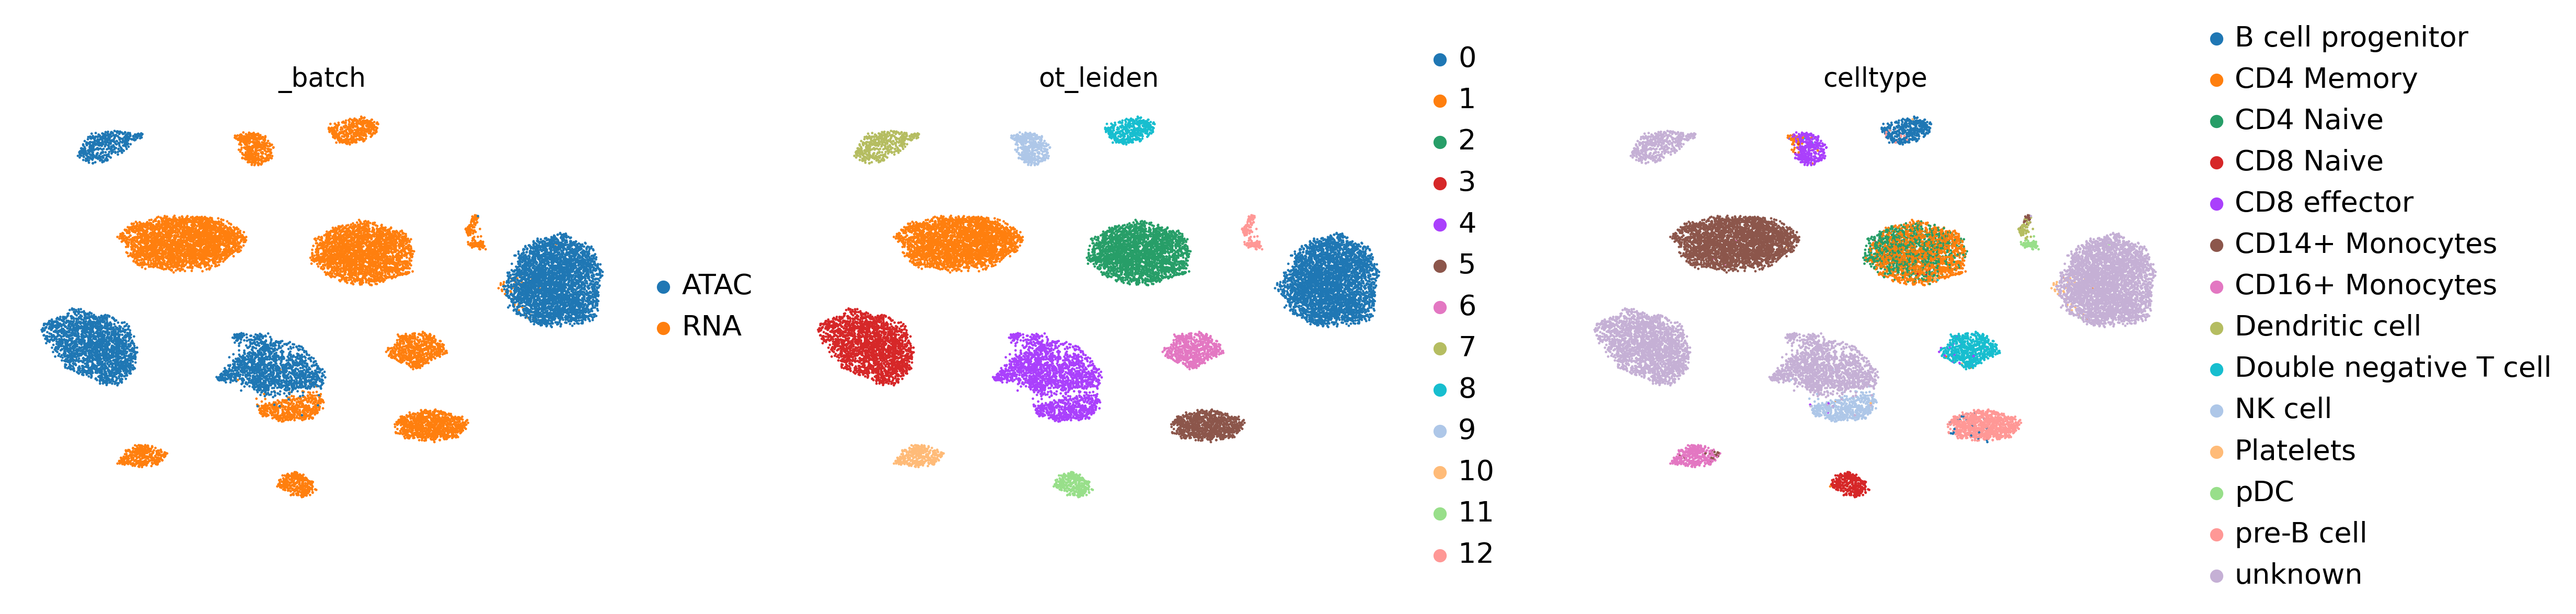

In [33]:
sc.settings.set_figure_params(dpi=130,dpi_save=200,figsize=[6,4])
sc.pl.umap(adata_merge, color=['_batch','ot_leiden',"celltype"],frameon=False, legend_fontsize=15,legend_fontweight='bold')

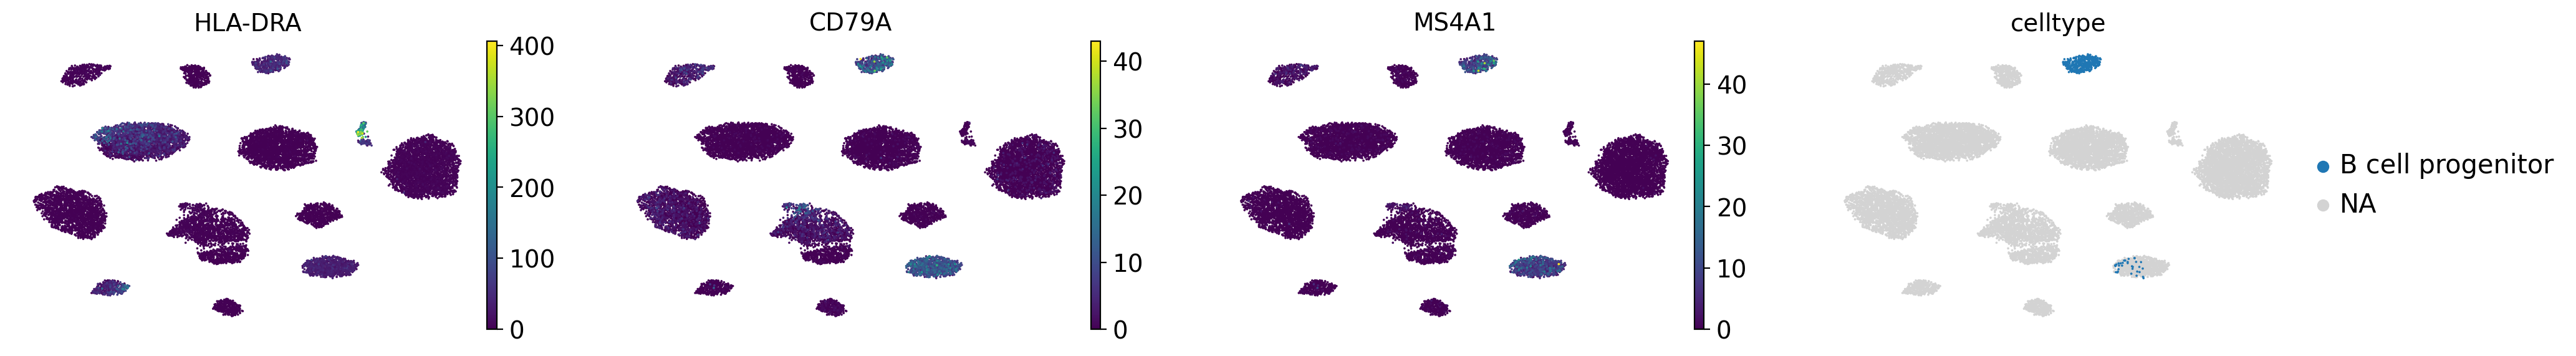

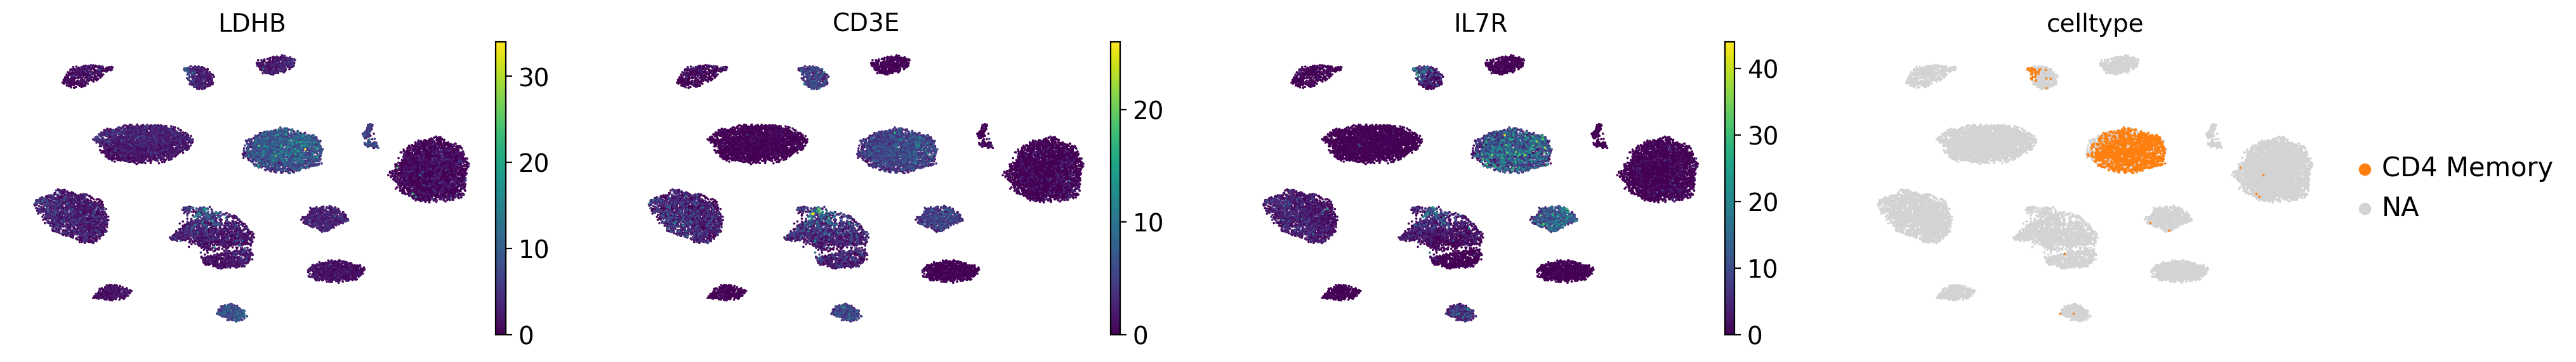

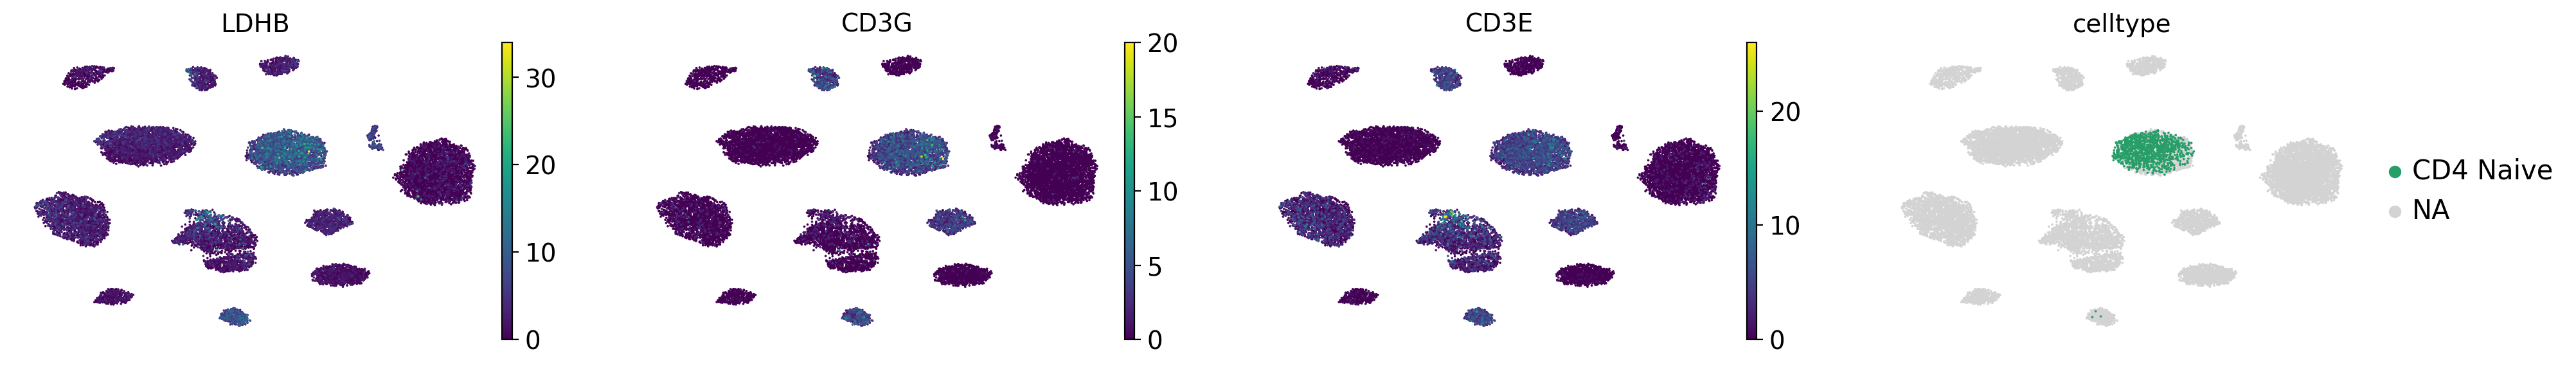

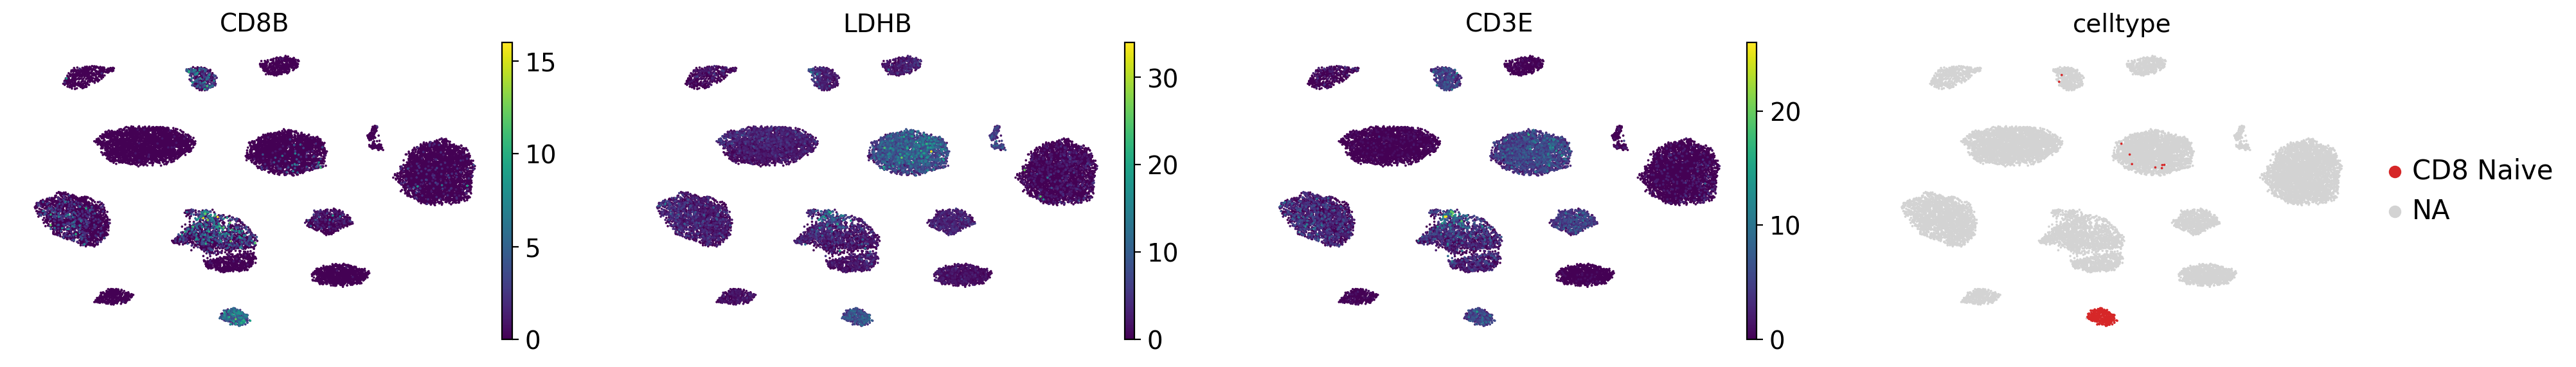

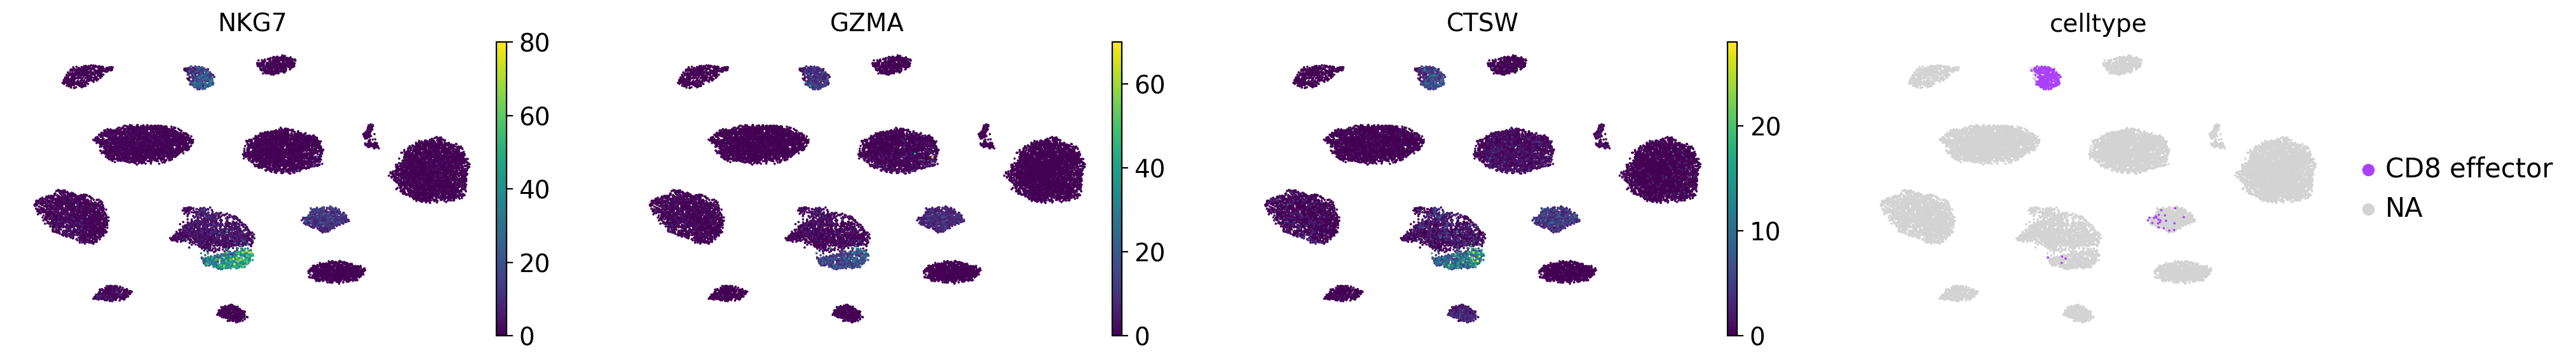

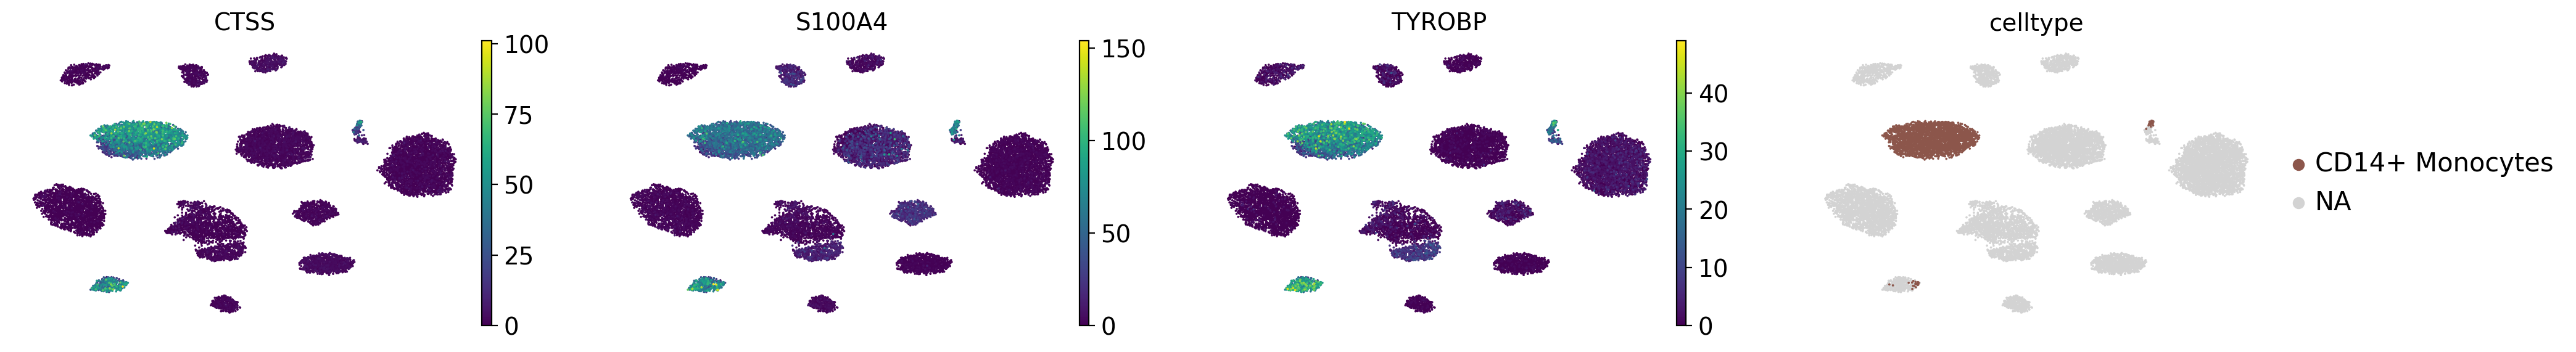

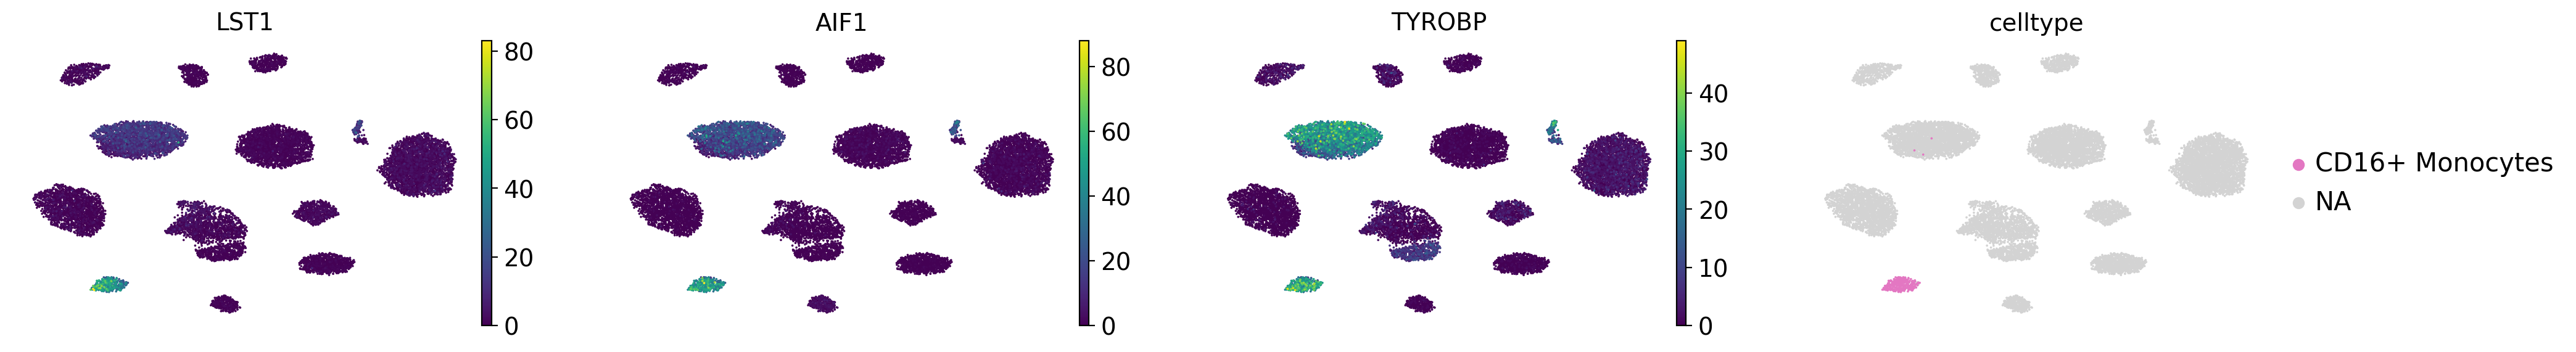

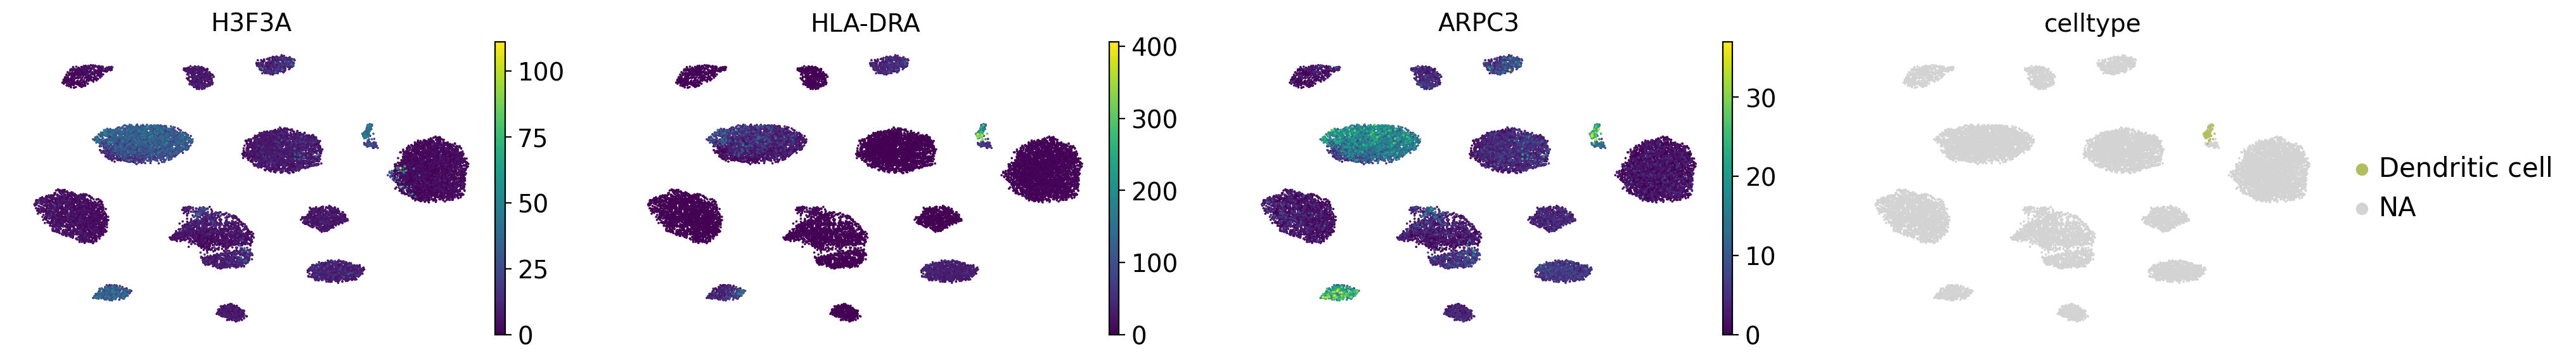

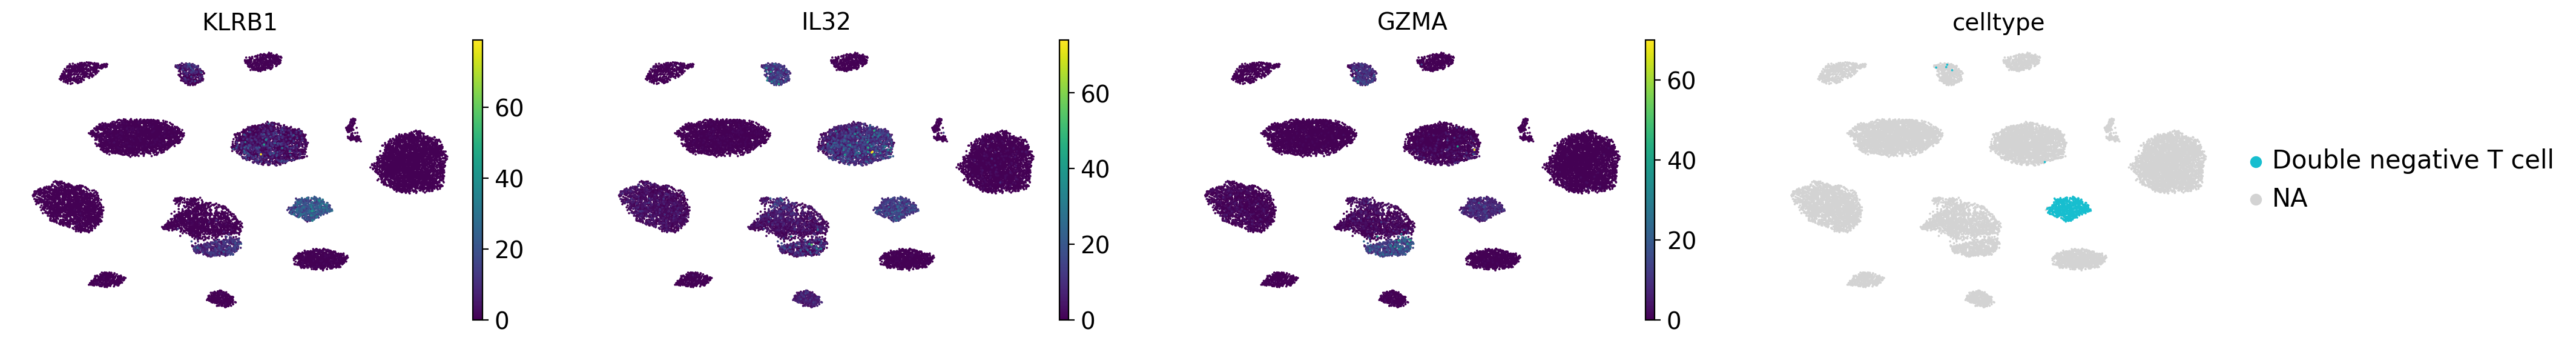

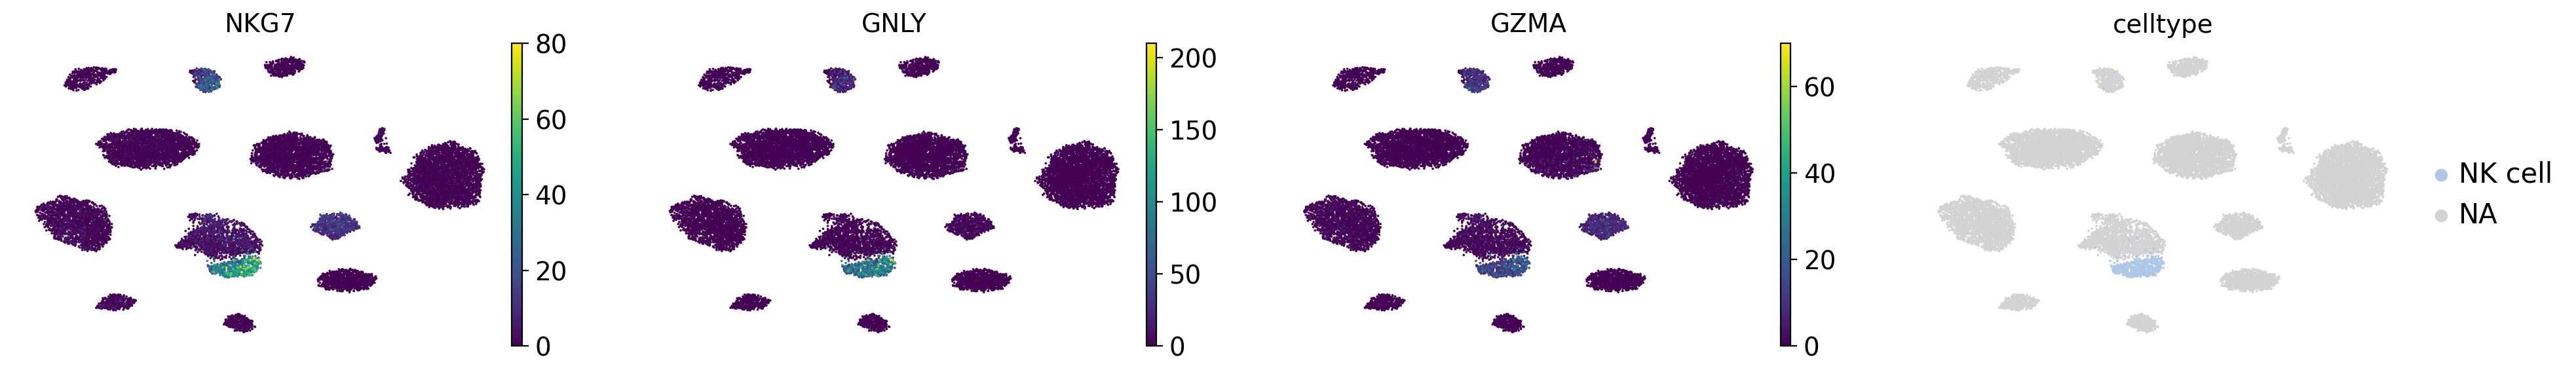

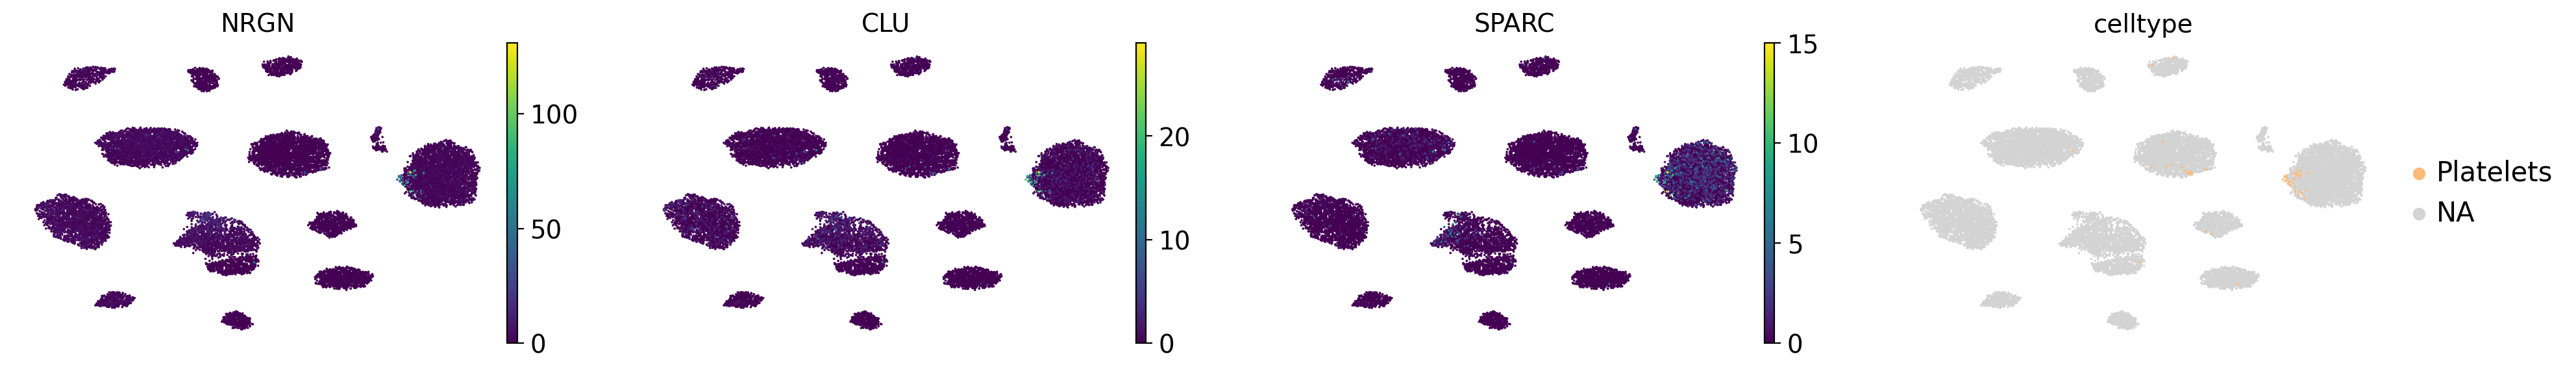

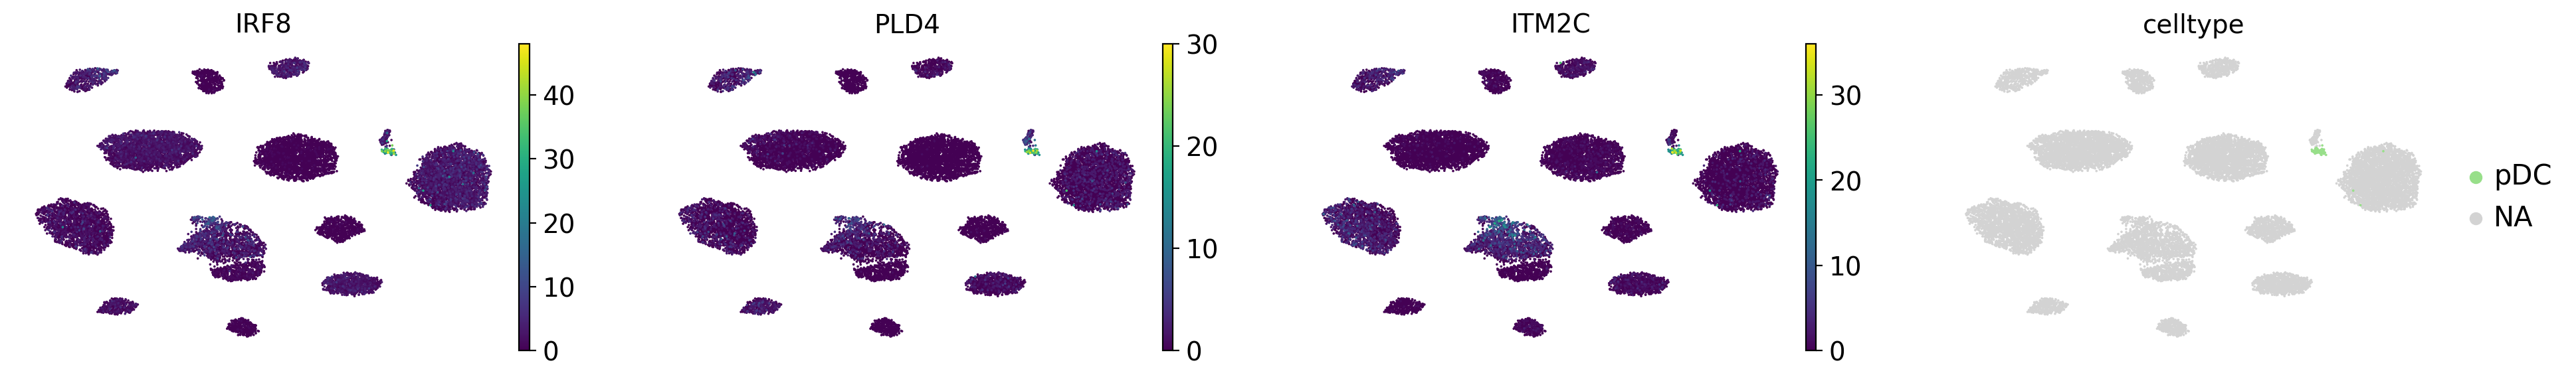

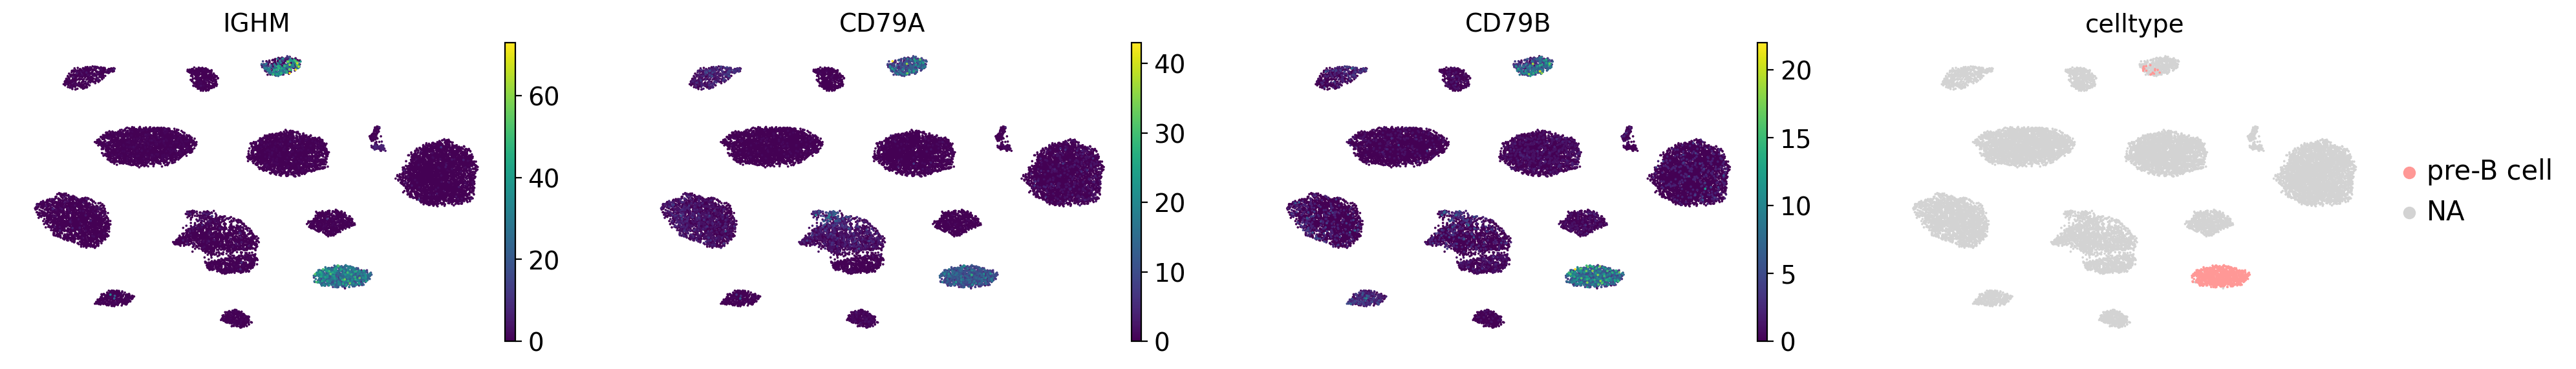

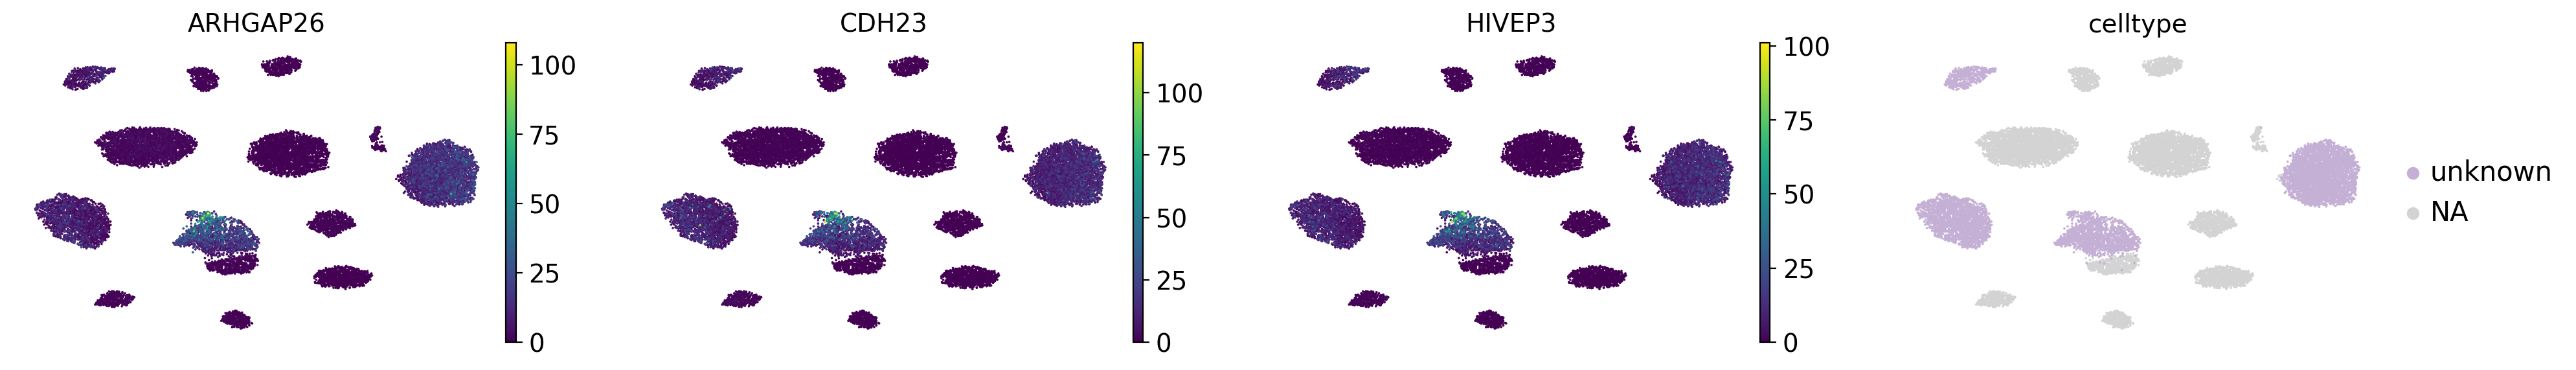

In [34]:
result = adata_merge.uns['rank_genes_groups']
allMarkers = []
for cluster in result['names'].dtype.names:
  current = pd.DataFrame({"gene": result["names"][cluster], "score": result["scores"][cluster], "logfoldchange": result["logfoldchanges"][cluster], "pval": result["pvals"][cluster], "pval_adj": result["pvals_adj"][cluster], "cluster": cluster})
  allMarkers.append(current)

allMarkers_OT = pd.concat(allMarkers)
for gene in list(allMarkers_OT.cluster.unique()):
  mark = allMarkers_OT[allMarkers_OT["cluster"] == gene].head(3)["gene"].to_list()#
  mark.append("celltype")

  sc.settings.set_figure_params(dpi=100,dpi_save=200,figsize=[5,3])
  sc.pl.umap(adata_merge, color=mark, groups=gene, frameon=False, legend_fontsize=15,legend_fontweight='bold')

In [35]:
def compute_asw(arr, batch_label, cell_label):

    batch_score = silhouette_score(arr, batch_label)
    celltype_score = silhouette_score(arr, cell_label)


    return batch_score,celltype_score

def compute_ARI_NMI(adata, key):

    X = adata.obsm[key]
    Y_batchcluster = adata.obs['_batch'].tolist()
    Y_batchnum = len(set(Y_batchcluster))

    Y_cellcluster = adata.obs['celltype'].tolist()
    Y_cellnum = len(set(Y_cellcluster))

    km_batch = KMeans(n_clusters=Y_batchnum, init='k-means++', max_iter=30)
    km_batch.fit(X)
    y_batch = km_batch.predict(X)
    batch_ARI = adjusted_rand_score(Y_batchcluster,y_batch)
    batch_NMI = nmi(Y_batchcluster,y_batch)


    km_cell = KMeans(n_clusters=Y_cellnum, init='k-means++', max_iter=30)
    km_cell.fit(X)
    y_cell = km_cell.predict(X)
    cell_ARI = adjusted_rand_score(Y_cellcluster,y_cell)
    cell_NMI = nmi(Y_cellcluster, y_cell)


    return batch_ARI, cell_ARI,batch_NMI,cell_NMI

In [36]:
arr = adata_merge.obsm['X_emb']
batch_label = adata_merge.obs['_batch'].tolist()
cell_label = adata_merge.obs['ot_leiden'].tolist()
asw_batch_score_scDML, asw_celltype_score_scDML = compute_asw(arr, batch_label, cell_label)
batch_ARI_scDML, cell_ARI_scDML,batch_NMI_scDML,cell_NMI_scDML = compute_ARI_NMI(adata_merge, key='X_emb')

In [37]:
results_df = pd.DataFrame(data = {
    "Metric": ["ASW Batch", "ASW Cell Type", "ARI Batch", "ARI Cell Type", "NMI Batch", "NMI Cell Type"],
    "scDML": [asw_batch_score_scDML, asw_celltype_score_scDML, batch_ARI_scDML, cell_ARI_scDML, batch_NMI_scDML, cell_NMI_scDML]
})
results_df.set_index("Metric", drop=True, inplace=True)

In [38]:
results_df

scDML
Metric                 
ASW Batch      0.258388
ASW Cell Type  0.609408
ARI Batch      0.081027
ARI Cell Type  0.357269
NMI Batch      0.227707
NMI Cell Type  0.728474